In [1]:
import os
import sys
import glob
import pathlib
from copy import deepcopy
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import talib
from sklearn import preprocessing

In [2]:
""" 候选品种
RM0	czce	菜粕连续
MA0	czce	甲醇连续
FG0	czce	玻璃连续
"""

dfs = {}
symbols = []
future_list = glob.glob("D:/quant/data/futures/*")
future_list = sorted(future_list, key = lambda x: pathlib.Path(x).name[:-4].split(".")[-1])
for i in future_list:
    symbol = pathlib.Path(i).name[:-4]
    # if symbol == "AU0.shfe":
    df = pd.read_csv(i)
    if df.shape[0] > 100:
        dfs[symbol] = df
        symbols.append(symbol)
    # break

In [3]:
rm_df = dfs["RM0.czce"]
ma_df = dfs["MA0.czce"]
fg_df = dfs["FG0.czce"]

rm_df.shape, ma_df.shape, fg_df.shape

((2325, 6), (1843, 6), (2339, 6))

In [6]:
TASK = "clf"
def get_ma_feature(df):
    periods = list(range(3,31,1))
    print(periods)
    for i in periods:
        df[f"ma{i}"] = talib.EMA(df["close"], timeperiod=i)
        # df[f"open_ma{i}"] = talib.EMA(df["open"], timeperiod=i)
        
    # combines = combinations(periods, 2)
    # for i in combines:
    #     df[f"ma{i[0]}-{i[1]}"] = df[f"ma{i[0]}"] - df[f"ma{i[1]}"]
        
    return df

def get_change(df, base="open"):
    base_change = df.loc[1:,base].values - df.loc[:(df.shape[0]-2),base].values
    base_change_rate = base_change / df.loc[:(df.shape[0]-2),base].values*100
    return np.hstack([[0], base_change_rate])

def get_feature_df(df):
    df = deepcopy(df)
    assert TASK in ("clf","reg")
    # calculate up/down
    if TASK=="clf":
        close_change = get_change(df, base="close")
        close_open_rate = (df["close"] - df["open"]) / df["open"] * 100
        labels = []
        for cc,co in zip(np.hstack([close_change[1:], [0]]),
                         np.hstack([close_open_rate[1:], [0]])):
            if cc > 0 and  co > 0:
                label = 1 # buy
            # elif cc < 0 and co < 0:
            #     label = 0 # short
            else:
                label = 0 # no change
            labels.append(label)
        df["label"] = np.array(labels)
    if TASK=="reg":
        close_change = df.loc[1:,"close"].values - df.loc[:(df.shape[0]-2),"close"].values
        df["label"] = np.hstack([close_change, [0]]) # np.hstack([df["close"].values[1:], [0]])
    
    # calculate moving average
    df = get_ma_feature(df)
    
    # drop anomaly value
    df = df.dropna().reset_index(drop=True)
    df = df.drop(0, axis=0).reset_index(drop=True)
    df = df.drop([len(df)-1], axis=0).reset_index(drop=True)
    return df

def get_feature_label(df):
    remove_col = ["datetime","open","high","low","volume","label"]
    feature_df = df.drop(remove_col,axis=1)
    # feature_df = (feature_df-feature_df.min())/(feature_df.max()-feature_df.min())
    feature_df = (feature_df-feature_df.mean())/(feature_df.std())
    features = feature_df.values
    labels = df["label"].values
    return features, labels

In [7]:
get_feature_df(ma_df).head()

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


,datetime,open,high,low,close,volume,label,ma3,ma4,ma5,...,ma21,ma22,ma23,ma24,ma25,ma26,ma27,ma28,ma29,ma30
0,2015-02-06,2141,2171,2136,2164,2532620,0,2141.814713,2133.451427,2125.868214,...,2061.604176,2059.477592,2057.216286,2054.093764,2051.328130,2049.457190,2046.669708,2042.774194,2038.901149,2035.370968
1,2015-02-09,2157,2163,2132,2143,1496256,0,2142.407357,2137.270856,2131.578809,...,2069.003797,2066.740410,2064.364929,2061.206263,2058.379812,2056.386287,2053.550444,2049.686319,2045.841073,2042.314776
2,2015-02-10,2147,2158,2124,2131,1338972,1,2136.703678,2134.762514,2131.385873,...,2074.639815,2072.328201,2069.917851,2066.789762,2063.965981,2061.913229,2059.082555,2055.294159,2051.518335,2048.036404
3,2015-02-11,2129,2140,2116,2138,1302640,1,2137.351839,2136.057508,2133.590582,...,2080.399832,2078.038792,2075.591364,2072.486581,2069.660905,2067.549286,2064.719515,2060.998010,2057.283779,2053.840507
4,2015-02-12,2135,2163,2127,2163,1660278,1,2150.175920,2146.834505,2143.393721,...,2087.908938,2085.426723,2082.875417,2079.727654,2076.840836,2074.619709,2071.739550,2068.032630,2064.331527,2060.883055


## analyse

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


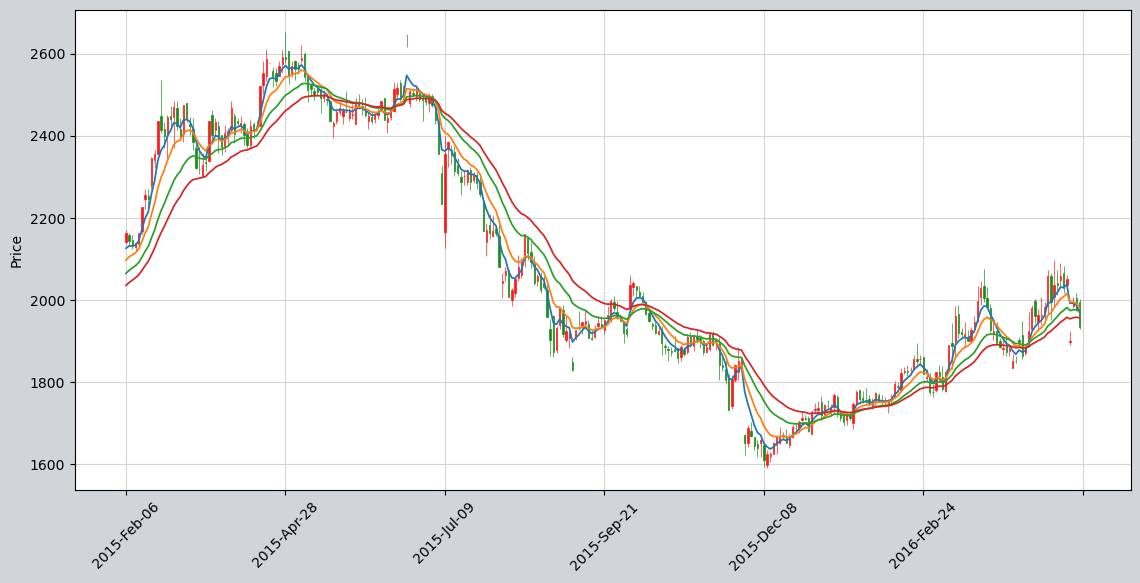

In [16]:
"""
https://blog.csdn.net/Shepherdppz/article/details/117575286
"""
import mplfinance as mpf
def plot_candle(df):
    df = deepcopy(df)
    # 设置mplfinance的蜡烛颜色，up为阳线颜色，down为阴线颜色
    my_color = mpf.make_marketcolors(up='r',
                                     down='g',
                                     edge='inherit',
                                     wick='inherit',
                                     volume='inherit')
    # 设置图表的背景色
    my_style = mpf.make_mpf_style(marketcolors=my_color,
                                  figcolor='(0.82, 0.83, 0.85)',
                                  gridcolor='(0.82, 0.83, 0.85)')


    fig = mpf.figure(style=my_style, figsize=(12, 8), facecolor=(0.82, 0.83, 0.85))
    # 添加三个图表，四个数字分别代表图表左下角在figure中的坐标，以及图表的宽（0.88）、高（0.60）
    ax1 = fig.add_axes([0.06, 0.25, 0.88, 0.60])

    # 读取的测试数据索引为字符串类型，需要转化为时间日期类型
    df.index = pd.to_datetime(df.datetime)

    # 通过ax=ax1参数指定把新的线条添加到ax1中，与K线图重叠
    ap = mpf.make_addplot(df[['ma5', 'ma10', 'ma20', 'ma30']], ax=ax1)
    
    # 调用plot()方法，注意传递addplot=ap参数，以添加均线
    mpf.plot(df,
             ax=ax1,
             addplot=ap,
             type='candle',
             style=my_style)

    fig.show()	
    
analyse = get_feature_df(ma_df)
plot_candle(analyse.iloc[:300])

## classification

In [17]:
TASK = "clf"

In [18]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]

df = dfs["MA0.czce"]
# df = get_feature_df(df)
train_df = df[df["datetime"] < '2021-07-01'].reset_index(drop=True)
valid_df = df[(df["datetime"] > "2021-07-01") & (df["datetime"] < "2022-01-01")].reset_index(drop=True)
test_df = df[df["datetime"] > "2022-01-01"].reset_index(drop=True)

train_data = get_feature_label(get_feature_df(train_df))
valid_data = get_feature_label(get_feature_df(valid_df))
test_data = get_feature_label(get_feature_df(test_df))

print(len(train_data[0]), len(valid_data[0]), len(test_data[0]), train_data[0].shape)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
1548 93 108 (1548, 29)


In [19]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix

In [20]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(train_data[0], train_data[1])
# clf.predict(valid_data[0]), valid_data[1]

LogisticRegression(random_state=0)

In [22]:
clf.predict_proba(valid_data[0])

array([[0.5581889 , 0.4418111 ],
       [0.58726152, 0.41273848],
       [0.58890153, 0.41109847],
       [0.58487844, 0.41512156],
       [0.57277582, 0.42722418],
       [0.56777905, 0.43222095],
       [0.58491184, 0.41508816],
       [0.5672851 , 0.4327149 ],
       [0.56739323, 0.43260677],
       [0.55143807, 0.44856193],
       [0.55436225, 0.44563775],
       [0.55369775, 0.44630225],
       [0.54880523, 0.45119477],
       [0.55838174, 0.44161826],
       [0.56681447, 0.43318553],
       [0.56735107, 0.43264893],
       [0.57058515, 0.42941485],
       [0.59344896, 0.40655104],
       [0.59277725, 0.40722275],
       [0.58842178, 0.41157822],
       [0.57380386, 0.42619614],
       [0.57710657, 0.42289343],
       [0.56728735, 0.43271265],
       [0.58137146, 0.41862854],
       [0.58232623, 0.41767377],
       [0.56070492, 0.43929508],
       [0.58009718, 0.41990282],
       [0.59886962, 0.40113038],
       [0.58818236, 0.41181764],
       [0.61500038, 0.38499962],
       [0.

In [36]:
y_true, y_pred = valid_data[1], (clf.predict_proba(valid_data[0])[:,1]+0.49).astype("int") # clf.predict(valid_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[42  7]
 [40  4]]
              precision    recall  f1-score   support

           0       0.51      0.86      0.64        49
           1       0.36      0.09      0.15        44

    accuracy                           0.49        93
   macro avg       0.44      0.47      0.39        93
weighted avg       0.44      0.49      0.41        93



In [27]:
y_true, y_pred = valid_data[1], (clf.predict_proba(valid_data[0])[:,1]+0.55).astype("int")
precision_score(y_true, y_pred), recall_score(y_true, y_pred)

(0.4666666666666667, 0.4772727272727273)

In [126]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=6, random_state=0)
clf.fit(train_data[0], train_data[1])

RandomForestClassifier(max_depth=6, random_state=0)

In [128]:
clf.predict_proba(valid_data[0])

array([[0.47612438, 0.52387562],
       [0.52645025, 0.47354975],
       [0.54288365, 0.45711635],
       [0.53278722, 0.46721278],
       [0.51140657, 0.48859343],
       [0.49978609, 0.50021391],
       [0.49417001, 0.50582999],
       [0.53813723, 0.46186277],
       [0.56245685, 0.43754315],
       [0.57390798, 0.42609202],
       [0.60179432, 0.39820568],
       [0.61208946, 0.38791054],
       [0.57648169, 0.42351831],
       [0.57831951, 0.42168049],
       [0.58311674, 0.41688326],
       [0.56196723, 0.43803277],
       [0.52507057, 0.47492943],
       [0.52873508, 0.47126492],
       [0.5399754 , 0.4600246 ],
       [0.5504321 , 0.4495679 ],
       [0.53394293, 0.46605707],
       [0.53529846, 0.46470154],
       [0.54313289, 0.45686711],
       [0.55545377, 0.44454623],
       [0.55954579, 0.44045421],
       [0.58511595, 0.41488405],
       [0.60451423, 0.39548577],
       [0.59734786, 0.40265214],
       [0.60580598, 0.39419402],
       [0.58122447, 0.41877553],
       [0.

In [127]:
y_true, y_pred = valid_data[1], clf.predict(valid_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[37 12]
 [33 11]]
              precision    recall  f1-score   support

           0       0.53      0.76      0.62        49
           1       0.48      0.25      0.33        44

    accuracy                           0.52        93
   macro avg       0.50      0.50      0.48        93
weighted avg       0.50      0.52      0.48        93



In [40]:
precision_score(clf.predict(valid_data[0]), valid_data[1]), recall_score(clf.predict(valid_data[0]), valid_data[1])

(0.20454545454545456, 0.47368421052631576)

## regression

In [67]:
TASK = "reg"

In [68]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]

df = dfs["MA0.czce"]
# df = get_feature_df(df)
train_df = df[df["datetime"] < '2021-07-01'].reset_index(drop=True)
valid_df = df[(df["datetime"] > "2021-07-01") & (df["datetime"] < "2022-01-01")].reset_index(drop=True)
test_df = df[df["datetime"] > "2022-01-01"].reset_index(drop=True)

train_data = get_feature_label(get_feature_df(train_df))
valid_data = get_feature_label(get_feature_df(valid_df))
test_data = get_feature_label(get_feature_df(test_df))

print(len(train_data[0]), len(valid_data[0]), len(test_data[0]), train_data[0].shape)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
1548 93 108 (1548, 407)


In [69]:
from sklearn.metrics import mean_squared_error

In [75]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_data[0], train_data[1])
reg.predict(valid_data[0])
mean_squared_error(valid_data[1], reg.predict(valid_data[0]))

2.2748856391564243e+24

In [71]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=6, random_state=0)
rf_reg.fit(train_data[0], train_data[1])
rf_reg.predict(valid_data[0])
mean_squared_error(valid_data[1], rf_reg.predict(valid_data[0]))

8641.91992659154

## plot

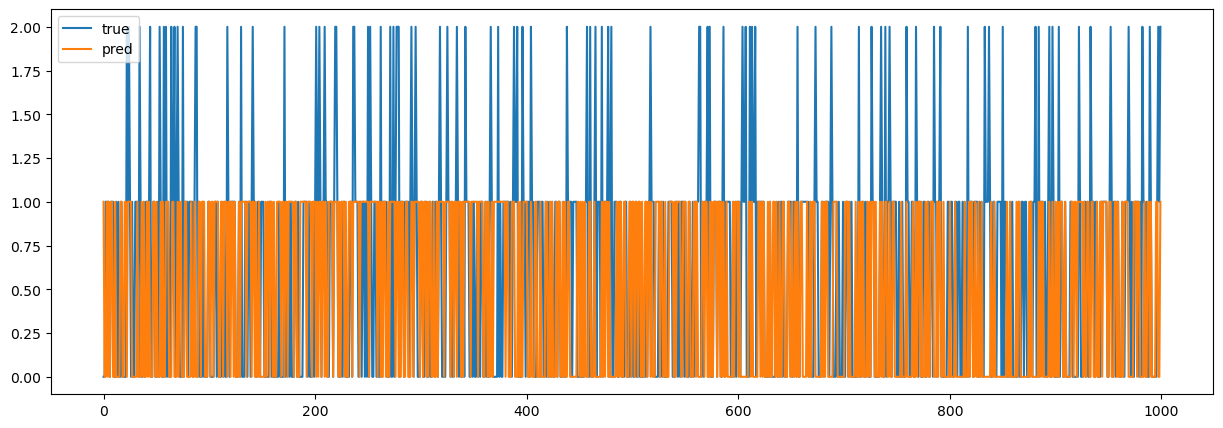

0.62


In [84]:
import matplotlib.pyplot as plt

def evaluate(model, data, label):
    fig = plt.figure(figsize = (15,5))
    plt.plot(label, label="true")
    preds = model.predict(data)
    plt.plot(preds, label="pred")
    plt.legend()
    plt.show()
    
    print(np.mean((preds - label)**2))

evaluate(clf, train_data[0][:1000], train_data[1][:1000])

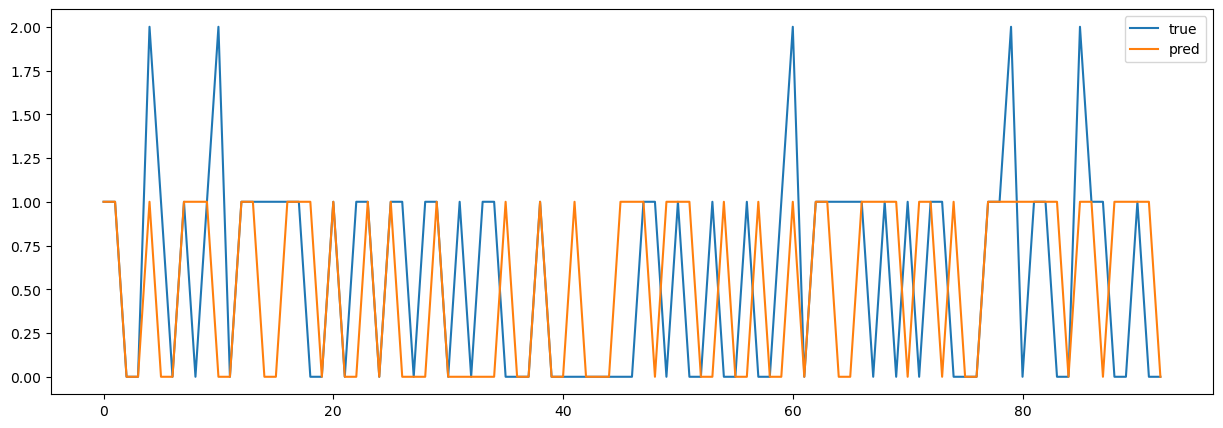

0.4838709677419355


In [85]:
evaluate(clf, valid_data[0], valid_data[1])

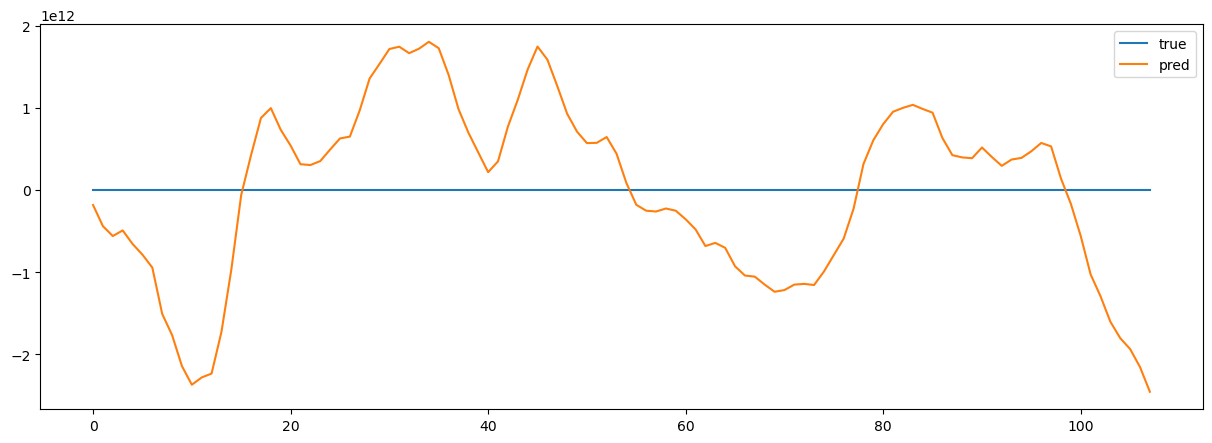

1.1532876436325428e+24


In [78]:
evaluate(reg, test_data[0], test_data[1])

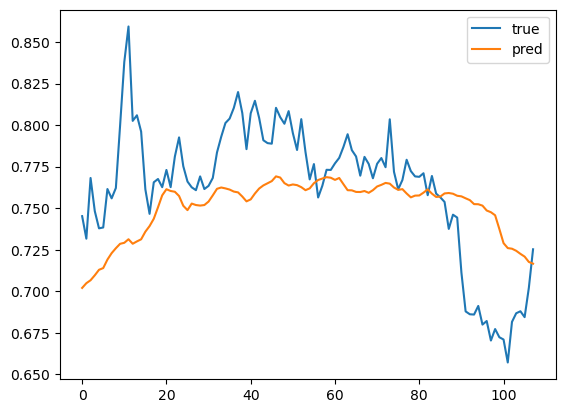

In [90]:
import numpy as np

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

import matplotlib.pyplot as plt

plt.plot(test_data[1], label="true")
plt.plot(preds, label="pred")
plt.legend()
plt.show()

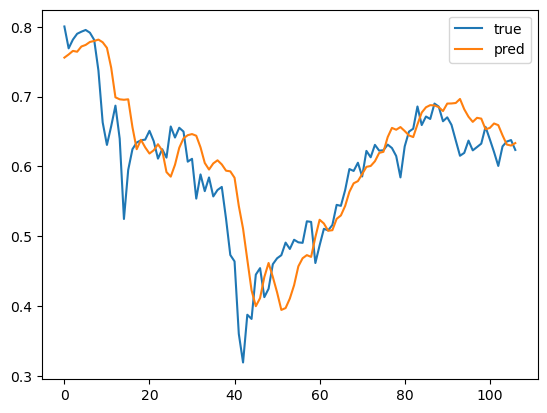

In [6]:
import numpy as np

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

import matplotlib.pyplot as plt

plt.plot(test_data[1], label="true")
plt.plot(preds, label="pred")
plt.legend()
plt.show()

In [21]:
loss = (preds - test_data[1]) ** 2
np.mean(loss)

0.7017188418002445

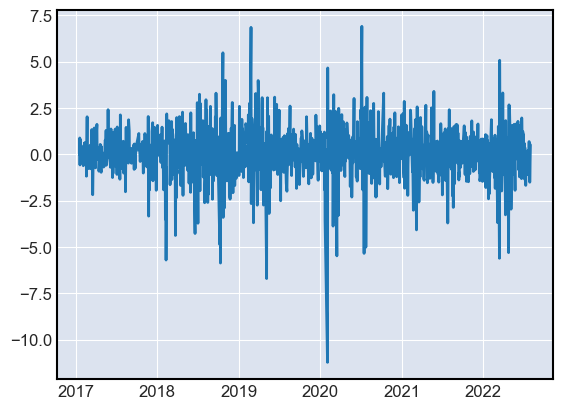

In [40]:
plt.plot(df_stockload["close_change"])

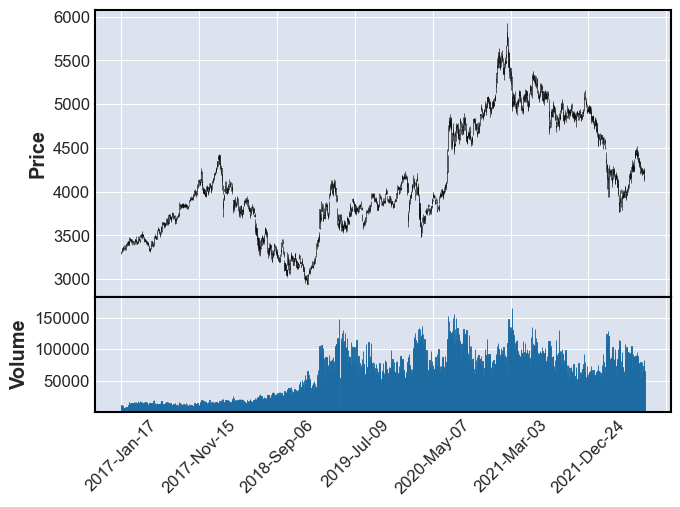

In [39]:
import mplfinance as mpf 

df_stockload = dfs["IF0.cffex"]
df_stockload.index = pd.to_datetime(df_stockload['datetime'])

mpf.plot(df_stockload,type='candle', volume=True)

In [126]:
a = np.array([])
b = np.expand_dims(a, axis=0)

In [127]:
len(a.shape)

1

In [128]:
a,b

(array([], dtype=float64), array([], shape=(1, 0), dtype=float64))